In [ ]:
import numpy as np

In [ ]:
np.random.seed(42)

In [ ]:
# Generate dataset
x = np.random.rand(100,1) #create 100 rows and 1 column matrix with the values between 0 and 1
y = 1 + 2*x + .1*np.random.randn(100,1) # generate y values --> add bias of 1, with the weight of 2 and standard deviation of 0.1 for the noise

In [ ]:
# shuffle the data
idx = np.arange(100)
np.random.shuffle(idx)
train_idx = idx[:80]
val_idx = idx[80:]

In [ ]:
x_train = x[train_idx]
y_train = y[train_idx]
x_val = x[val_idx]
y_val = y[val_idx]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

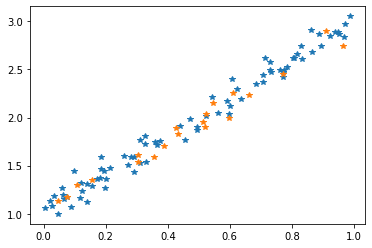

In [ ]:
plt.plot(x_train, y_train, '*')
plt.plot(x_val, y_val, '*')

In [ ]:
# From the graph, it is obvious that the bias is close to 1 and the slope (weight/parameter) is 2

In [ ]:
# Lets derive the bias and weight values from the regular regression method as well as pytorch framework

In [ ]:
# Linear regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
print('Weight:',lin_reg.coef_)
print('Bias:',lin_reg.intercept_)

Weight: [[1.96896447]]
Bias: [1.02354075]


In [ ]:
# Linear regression calculates the weight and bias close to its real value

In [ ]:
# Lets use Numpy library to find the weight and bias
a = np.random.rand(1) # initialize random bias value
b = np.random.rand(1) # initalize random weight value

epochs = 1000
lr = 1e-1

for epoch in range(epochs):
  # prediction
  yhat = a + b * x_train
  # error
  error = y_train - yhat
  # loss
  loss = (error**2).mean()
  # calculate gradient
  a_grad = -2 * error.mean()
  b_grad = -2 * (x_train*error).mean()
  # update parameter
  a -= lr*a_grad
  b -= lr*b_grad

print(f'weight: {b} \nbias: {a}')

weight: [1.9689642] 
bias: [1.02354089]


In [ ]:
# Linear regression and Numpy libraries provides the same weight and bias

In [ ]:
# Let do it with pytorch

import torch
import torch.optim as optim
import torch.nn as nn


In [ ]:
# select the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# convert the numpy format data to tensor form
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
x_val_tensor = torch.from_numpy(x_val).float().to(device)
y_val_tensor = torch.from_numpy(y_val).float().to(device)



In [ ]:
# model 
model = nn.Sequential(nn.Linear(1,1)).to(device)


In [ ]:
# loss function
loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
# set optimizer
lr = 1e-1
opt = optim.SGD(model.parameters(), lr = lr)

In [ ]:
for epoch in range(epochs):
  model.train()
  yhat = model(x_train_tensor)
  loss = loss_fn(y_train_tensor, yhat)
  loss.backward()
  opt.step()
  opt.zero_grad()
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


In [ ]:
# Pytorch found weight and bias....

In [ ]:
# So far we have learnt to use pytorch for linear model

In [ ]:
# Lets build a complete model with pytorch

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.dataset import random_split

# choose between CPU and GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# generate dataset
x = np.random.rand(100,1)
y = 1 + 2*x + 0.1*np.random.randn(100,1)

# convert numpy data format to tensor format
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# create the tuples from x and y input data using TensorDataset to slice the dataset
dataset = TensorDataset(x_tensor, y_tensor)
train_dataset, val_dataset = random_split(dataset, [80,20])

# Dataset is split into many batches using Dataloader
train_dl = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=10, shuffle=True)

# write a function to call train_step function which fit, cal loss, cal grad, opt param, and set param to zero and return loss
def make_train_step(model, loss_fn, optimizer):
  def train_step(x, y):
    # set the model to train
    model.train()
    # predict
    yhat = model(x)
    # cal loss
    loss = loss_fn(y, yhat)
    # cal gradient
    loss.backward()
    # update param
    optimizer.step()
    # set grad to zero
    optimizer.zero_grad()
    return loss.item()
  return train_step

# provide learning rate and epoch 
lr = 1e-1
epochs = 100

# define model, loss function and optimizer
model = nn.Sequential(nn.Linear(1,1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
opt = optim.SGD(model.parameters(), lr=lr)

# instatiate make_train_step function to train_step
train_step = make_train_step (model, loss_fn, opt)

# create empty list to store training and validation loss of each epoch/training
training_losses = []
validataion_losses = []

# iterate each epoch and fit the model with the training set
for epoch in range(epochs):
  # create batch_losses empty list to append the batch_loss of each batch
  batch_losses = []
  # iterate each batch from the train_dl
  for x_batch, y_batch in train_dl:
    # convert tensor format to gpu tensor format
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    # store the loss value of each batch in loss variable
    loss = train_step(x_batch, y_batch)
    # append the loss into batch_losses list
    batch_losses.append(loss)

  # take a mean of batch losses and append this particular epoch loss to training_losses
  training_loss = np.mean(batch_losses)
  training_losses.append(training_loss)

  # evaluate the model with the validation dataset
  # evaluation method doesn't require gradient
  with torch.no_grad():
    # create val_losses empty list to append the val_loss of each batch
    val_losses = []
    # iterate batches of validatation dataset
    for x_val, y_val in val_dl:
      # convert tensor format to gpu tensor format
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      # evaluate the model
      model.eval()
      # predict the model
      yhat = model(x_val)
      # calculate the loss
      val_loss = loss_fn(y_val, yhat).item()
      # append the loss to val_losses
      val_losses.append(val_loss)
    # append the mean value of losses each val_losses to validation_losses
    validation_loss = np.mean(val_losses)
    validataion_losses.append(validation_loss)

  if (epoch+1) % 10 == 0:
    print(f'[{epoch+1}], training_loss: {training_loss:.3f}, validation_loss: {validation_loss:.3f} ')

print(model.state_dict())

[10], training_loss: 0.023, validation_loss: 0.026 
[20], training_loss: 0.011, validation_loss: 0.010 
[30], training_loss: 0.009, validation_loss: 0.008 
[40], training_loss: 0.009, validation_loss: 0.007 
[50], training_loss: 0.009, validation_loss: 0.007 
[60], training_loss: 0.009, validation_loss: 0.007 
[70], training_loss: 0.009, validation_loss: 0.007 
[80], training_loss: 0.009, validation_loss: 0.007 
[90], training_loss: 0.009, validation_loss: 0.007 
[100], training_loss: 0.009, validation_loss: 0.007 
OrderedDict([('0.weight', tensor([[1.9998]], device='cuda:0')), ('0.bias', tensor([1.0237], device='cuda:0'))])
